In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import re
import math

sns.set_context('talk')

# Data collection

To select the best movies to learn English, I used three differente data. 
1. Oxford's 5000-word list: Available on Oxford's website (https://www.oxfordlearnersdictionaries.com/wordlists/oxford3000-5000)
2. BNC/COCA word family list: It's created by Paul Nation and provides word lists including all the forms of a word. Available here: https://www.laurenceanthony.net/resources/wordlists/
3. IMDb dataset: Here I used two files of IMDb data available here https://datasets.imdbws.com/
    - title.ratings.tsv: Contains the IMDb rating and votes information for titles.
    - title.basics.tsv.gz: Contains titles, release year, genre, etc.
4. Movies Transcripts: I extracted transcripts of popular movies from different sources. You may google 'movies transcripts' and find the transcript of your favorite movie


First, let's read each dataset

In [103]:
%store -r df_oxford
%store -r df_nation
%store -r df_ratings
%store -r df_imdb_movies

# Data Cleaning

### Oxford Dataset

The frame df_oxford has the columns 'base_forms', 'type_words' and 'levels', while df_nation has 'base_forms', 'all_forms' and 'levels'. Note that the criteria in the 'levels' columns are different between the two dataframes.

The Oxford 5000 contains duplicate words in the column 'base_forms' since one word can have different meaning e.g. the word 'age' as a noun is considered A1 level, but as a verb is considered B1 level. To deal with this we'll do the following
1. Group by levels (A1, A2, ...C1) and drop duplicates within the same level
2. Drop duplicates from different levels and keep the lowest level (keep='first'). For the example above only the word 'age' at A1 would remain

In [104]:
#The oxford list contains two words with numbers 'lie1' and 'lie2'. We'll remove the numbers:
df_oxford = df_oxford.assign(base_forms=df_oxford['base_forms'].apply(lambda x: re.sub('(\d)', '',x).strip()))

# To avoid repetition we also need to remove the marginal words ah (148) and oh (3600) in Oxford's list because they're
#already considered in a bigger list in the df_nation frame inside the level 'marginal words'
df_oxford.drop([148, 3600], axis=0, inplace=True)

#It's necessary to lower case the base_forms column in df_oxford to later match it with df_nation
df_oxford['base_forms'] = df_oxford['base_forms'].apply(lambda x:x.lower())

#dropping the duplicates within the same level
df_oxford_a1 = df_oxford[df_oxford['levels']=='a1'].drop_duplicates(['base_forms'])
df_oxford_a2 = df_oxford[df_oxford['levels']=='a2'].drop_duplicates(['base_forms'])
df_oxford_b1 = df_oxford[df_oxford['levels']=='b1'].drop_duplicates(['base_forms'])
df_oxford_b2 = df_oxford[df_oxford['levels']=='b2'].drop_duplicates(['base_forms'])
df_oxford_c1 = df_oxford[df_oxford['levels']=='c1'].drop_duplicates(['base_forms'])

#then we concatenate the five frames to obtain the df_oxfrod without repetition within the same level
df_oxford = pd.concat([
    df_oxford_a1, df_oxford_a2, df_oxford_b1, df_oxford_b2, df_oxford_c1
], axis=0)

#now we drop duplicates from different levels keeping the lowest level (keep='first')
df_oxford = df_oxford.sort_values(['base_forms', 'levels']).drop_duplicates('base_forms', keep='first')

The following table shows the number base words for each level table after cleaning the data

In [110]:
df_oxford.groupby('levels').count()

,base_forms,type_words
levels,,
a1,897,897
a2,791,791
b1,689,689
b2,1297,1297
c1,1278,1278


In [81]:
#before merging the df_oxford and df_nation frames we need to change the 'levels' column name 
#to differentiate them
df_oxford.rename(columns={'levels':'oxford_levels'}, inplace=True)
df_nation.rename(columns={'levels':'nation_levels'}, inplace=True)

#let's merge the two dataframes and name it 'df_oxford_all_forms'. 
df_oxford_all_forms =  pd.merge(df_oxford, df_nation, on='base_forms')

#Note1: some of the words that dont merge are only compound words 
#Note2: other words that dont merge are 'all_forms' words inside the 'base_form' column in the Oxford's list
#For example the word 'acceptable' is found in 'base_form' when actually it comes from the base form 'accept'
#Fortunately all this words are already considered inside 'all_forms' in  df_nation; therefore, it's already in df_oxford_all_forms. 
#You can verifi this by doing  -> pd.merge(df_oxford, df_nation, left_on='base_forms', right_on='all_forms')

#we'll only need this three columns for the analysis
df_oxford_all_forms = df_oxford_all_forms[['base_forms', 'all_forms', 'oxford_levels']]

#Let's include marginal words like 'oh', 'ah' and proper names like 'John' considered in df_nation
df_proper_names = df_nation[df_nation['nation_levels']==26]
df_proper_names = df_proper_names.assign(oxford_levels='proper_name')[['base_forms', 'all_forms', 'oxford_levels']]
#Drop this proper nouns to avoid repetition: #app 2026, #sue 20685. They're already counted as noun/verb in Oxford list
df_proper_names.drop([2026, 20685], axis=0, inplace=True)

df_marginal_words = df_nation[df_nation['nation_levels']==27]
df_marginal_words = df_marginal_words.assign(oxford_levels='marginal_words')[['base_forms', 'all_forms', 'oxford_levels']]

#append proper names and marginal words to df_oxford_all_forms
df_oxford_all_forms = df_oxford_all_forms.append(pd.concat([df_proper_names, df_marginal_words], axis=0), ignore_index=True)

The following table shows the number of unique base words on each level that will be used for the analysis along with its 'all_form' variantions

In [101]:
df_oxford_all_forms.drop_duplicates(['base_forms']).groupby('oxford_levels').count()

,base_forms,all_forms
oxford_levels,,
a1,783,783
a2,618,618
b1,462,462
b2,911,911
c1,855,855
marginal_words,38,38
proper_name,21660,21660


### Movies' transcripts Dataset

In [111]:
#merge the df_imdb_movies and df_ratings previously read
df_movies_rating = pd.merge(df_imdb_movies, df_ratings, on='tconst')
#lower case the 'primaryTitle' column so later we can merge it with the movies' transcripts
df_movies_rating['primaryTitle'] =  df_movies_rating['primaryTitle'].apply(lambda x:x.lower())

#pickle movies' transcripts. in this case the dataframe is already cleaned except for the transcript
#since cleaning movies' transcripts are time comsuming, i preferred to clean only the transcripts of the most popular movies (selected below)
df_movies = pickle.load(open('df_movies_clean_except_transcripts','rb'))
#lower case the 'titles' column to merge it with the df_movies_ratings
df_movies['titles'] =  df_movies['titles'].apply(lambda x:x.lower())

#merge df_movies and df_movies_rating
df_movies_analysis = pd.merge(df_movies, df_movies_rating, left_on=['titles', 'years'], 
         right_on=['primaryTitle', 'startYear'])
#sort the values descending by the numVotes (order by popularity)
df_movies_analysis = df_movies_analysis.sort_values(['numVotes', 'averageRating'], ascending=False)
#pick only the top 3000 most popular movies
df_movies_analysis = df_movies_analysis[:3000]
#reset index
df_movies_analysis = df_movies_analysis.reset_index().drop(['index'], axis=1)

In [113]:
#clean only the transcripts of the 3000 movies selected
from cleaning import clean_transcripts

final_round = lambda x: clean_transcripts(x)
df_movies_analysis['transcripts'] = df_movies_analysis['transcripts'].apply(final_round)

# Exploratory Data Analysis

### Document-Term Matrix

To obtain the vocabulary used in each movie we need to tokenize the transcripts. That is, break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse

#create instance on CountVectorizer. Then fit and transform the 'transcripts' columns
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df_movies_analysis['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_movies_analysis.index, columns=cv.get_feature_names())

In [115]:
#Transpose the df_dtm so we get movies titles in the columns and tokens in the rows
df_dtm = df_dtm.T

In [117]:
def get_statistics(indices):
    """Give the index of the movie and obtain the vocabulary coverage per level of each transcript """
    frames = []
    for index in indices:
        #obtain all the words said the in the movie 'n'
        df_dtm_column_n = df_dtm[[index]].loc[df_dtm[index]!=0]
        df_dtm_column_n = df_dtm_column_n.reset_index()
        df_dtm_column_n.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        #merge the df_dtm_column_n with the df_oxford_all_forms to obatin all vocabulary level of all the words mentioned in the movie
        df_count_words_level = pd.merge(df_dtm_column_n, df_oxford_all_forms[['all_forms', 'oxford_levels']],
                                                how='left', on='all_forms')
        #the words that dont have any Oxford level would go to the classification 'None on the list'
        df_count_words_level = df_count_words_level.fillna('None on the list')
        #turn the count column to integer type
        int_value = [int(i.item()) for i in df_count_words_level['count']]
        df_count_words_level['count'] = int_value

        #group the words in the transcript by level and then sum to the vocabulary coverage per level
        df_count_words_level = df_count_words_level.groupby(['oxford_levels']).sum()
        total_tokens = df_count_words_level['count'].sum()
        df_count_words_level['%'] = round(df_count_words_level['count'] / total_tokens * 100, 1)
        frames.append(df_count_words_level)
    return frames

In [118]:
#pick the indices of the 3000 movies selected. then call get_statistics()
indices = df_movies_analysis.index.values
df = get_statistics(indices)
dict_top_movies = dict(zip(indices, df))

In [125]:
#creating frames with % coverage from a1 to c1 in the columns for each movie
frames=[]
for index in dict_top_movies:
    total_tokens = dict_top_movies[index]['count'].sum()
    frame = dict_top_movies[index].drop(['count'], axis=1).rename(columns={'%':index}).T
    frame['tokens'] = total_tokens
    frames.append(frame)

In [130]:
#concatenate the frames appended and create cumulative coverage columns (CA, CB, CC)
df_statistics = pd.concat(frames, axis=0)
df_statistics['CA'] = df_statistics['a1'] + df_statistics['a2'] + df_statistics['marginal_words'] + df_statistics['proper_name'] 
df_statistics['CB'] = df_statistics['CA'] + df_statistics['b1'] + df_statistics['b2'] 
df_statistics['CC'] = df_statistics['CB'] + df_statistics['c1'] 
df_statistics['%'] = df_statistics['CC'] + df_statistics['None on the list']

In [136]:
df_statistics = df_statistics.fillna(0)
#Filter out transcripts with tokens less than 4000 words and with CA coverage less than 70% (total around 10% transcripts)
df_statistics = df_statistics[df_statistics['tokens']>4000]
df_statistics = df_statistics[df_statistics['CA']>=70]

The dataframe will look like the next table. This will help us analyze the data with graphs

In [137]:
df_statistics

,None on the list,a1,a2,b1,b2,c1,marginal_words,proper_name,tokens,CA,CB,CC,%
0,5.5,78.7,6.6,2.8,2.3,0.8,1.0,2.3,11292.0,88.6,93.7,94.5,100.0
1,3.9,79.3,7.0,2.3,2.7,1.4,0.6,2.9,12511.0,89.8,94.8,96.2,100.1
2,16.2,70.9,5.2,2.3,2.2,1.2,0.3,1.7,6577.0,78.1,82.6,83.8,100.0
3,4.2,79.6,7.1,2.2,2.4,0.9,1.1,2.5,13056.0,90.3,94.9,95.8,100.0
4,7.1,78.3,5.1,2.0,1.6,0.7,2.7,2.5,15704.0,88.6,92.2,92.9,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,3.2,84.4,6.2,1.8,2.4,0.7,0.8,0.4,7027.0,91.8,96.0,96.7,99.9
2996,7.0,75.8,6.6,2.8,2.4,1.5,1.4,2.5,10560.0,86.3,91.5,93.0,100.0
2997,7.7,73.2,6.8,3.4,3.7,0.9,1.4,2.9,4354.0,84.3,91.4,92.3,100.0
2998,4.9,79.9,5.3,2.3,1.6,0.9,3.4,1.7,7243.0,90.3,94.2,95.1,100.0


## Heatmap

Let's compare the vocabulary coverage for the movies Batman, Titanic, Harry Potter, Toy Story and Stuart Little.

In [138]:
df_heat = pd.concat([
    df_statistics[df_statistics.index.isin([13])],
    df_statistics[df_statistics.index.isin([28])],
    df_statistics[df_statistics.index.isin([137])],
    df_statistics[df_statistics.index.isin([45])],
    df_statistics[df_statistics.index.isin([1102])],
], axis=0)
df_heat = df_heat.rename(index={13:'Batman', 28:'Titanic',
                               137:'Harry potter', 45:'Toy story', 1102:'Stuart Little'})
df_heat = df_heat.sort_values(by=['CB'])
df_heat

,None on the list,a1,a2,b1,b2,c1,marginal_words,proper_name,tokens,CA,CB,CC,%
Toy story,7.5,75.3,6.9,1.7,2.3,1.1,3.1,2.1,7407.0,87.4,91.4,92.5,100.0
Batman,4.9,77.1,7.5,2.4,3.4,1.7,0.1,3.0,8896.0,87.7,93.5,95.2,100.1
Harry potter,5.0,77.6,6.1,2.7,2.6,1.2,0.7,4.0,8397.0,88.4,93.7,94.9,99.9
Titanic,5.0,79.8,7.1,2.1,2.3,0.8,0.6,2.3,11614.0,89.8,94.2,95.0,100.0
Stuart Little,3.2,79.2,7.3,3.9,3.5,0.8,0.1,2.1,13181.0,88.7,96.1,96.9,100.1


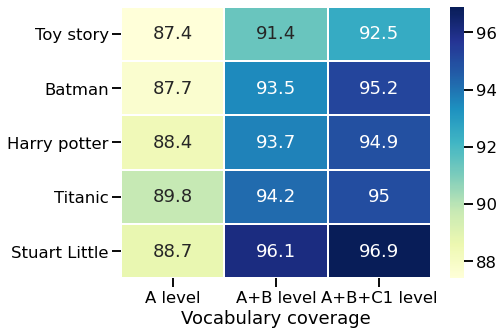

In [141]:
fig, ax = plt.subplots(1,1, figsize=(7.5,5))
ax = sns.heatmap(df_heat[['CA', 'CB', 'CC']], annot=True, linewidth=1, fmt='.3g', ax=ax, 
            cmap='YlGnBu', xticklabels= ['A level', 'A+B level', 'A+B+C1 level']
           )
ax.set_xlabel("Vocabulary coverage",fontsize=18)
fig.tight_layout()
# ax.figure.savefig('heatmap.png')

## Histogram A-level coverage

Mean:89.72208728652753


/Applications/anaconda3/envs/scrapping/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


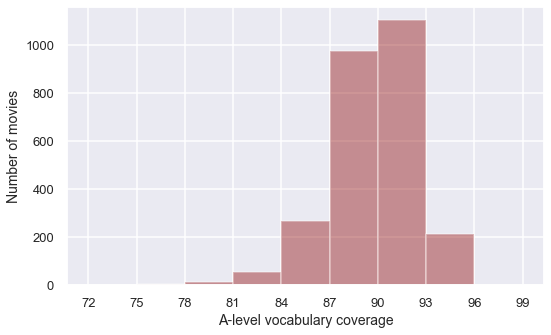

In [145]:
hmin, hmax = min(df_statistics['CA']), max(df_statistics['CA'])
minbin, maxbin = math.floor(hmin), math.ceil(hmax)
gap = maxbin - minbin
#choose number of beens
bins = 10
width = math.ceil(gap/bins)
print('Mean:'+str(df_statistics['CA'].mean()))

sns.set_style("darkgrid")
bins = np.arange(minbin,maxbin+width, width)
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax = sns.distplot(df_statistics['CA'], bins=bins, kde=False, color='darkred')
ax.set_xlabel("A-level vocabulary coverage",fontsize=14)
ax.set_ylabel("Number of movies",fontsize=14)
ax.tick_params(labelsize=13)
#Here you can set it to 'bin' so the ticks will match the end and beggining of bars OR you can
#set 'bin - HALF of the bar width' so the ticks will match the center of bars
plt.xticks(bins)
fig.tight_layout()
# ax.figure.savefig('A-coverage.png')

## Histogram B-level coverage

Mean:94.11244781783682


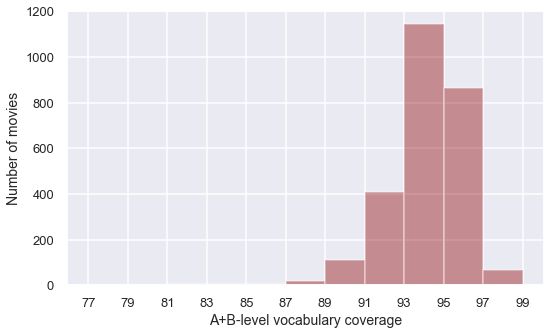

In [147]:
hmin, hmax = min(df_statistics['CB']), max(df_statistics['CB'])
minbin, maxbin = math.floor(hmin), math.ceil(hmax)
gap = maxbin - minbin
#choose number of beens
bins = 11
width = math.ceil(gap/bins)
print('Mean:'+str(df_statistics['CB'].mean()))

sns.set_style("darkgrid")
bins = np.arange(minbin, maxbin+width, width)
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax = sns.distplot(df_statistics['CB'], bins=bins, kde=False, color='darkred')
ax.set_xlabel("A+B-level vocabulary coverage",fontsize=14)
ax.set_ylabel("Number of movies",fontsize=14)
ax.tick_params(labelsize=13)
plt.xticks(bins)
fig.tight_layout()
# ax.figure.savefig('A+B-coverage.png')

## Selecting the top movies

According to the histograms about 200 movies covered the highest range of A-level vocabulary. Then we'll find out wich are the top 50 movies in that range. I had to make a trade-off between vocabulary coverage and movies' popularity (following the IMDb ratings) to come up with the top 50 movies 

In [149]:
top = 200
levels = ['CA', 'CB', 'CC', 'c1']

#the dicts will helps us group movie' index by level
dict_levels={}
dict_df = {}
#list for the max and min coverage in each level
list_max_coverage = []
list_min_coverage = []
for level in levels:
    df = df_statistics.sort_values(level, ascending=False)
    df = df[:top]
    list_max_coverage.append(df.sort_values(level, ascending=False)[level].max())
    list_min_coverage.append(df.sort_values(level, ascending=False)[level].min())
    index = df.index.values
    dict_levels['%s' % (level)] = index
    dict_df['%s' % (level)] = df

The max and min coverage in the highest range for each level is showed below

In [151]:
pd.DataFrame({'Max':list_max_coverage, 'Min':list_min_coverage}, index=levels)

,Max,Min
CA,96.3,93.0
CB,98.9,96.4
CC,99.1,97.1
c1,3.0,1.6


Create dataframes with the 200 movies in the highest range for A and A+B level

In [156]:
#merge by index (axis=1) to identify which movies cover most vocabulary. Alse we get the genre and release year.
level = 'CA'
df_A = pd.concat([df_movies_analysis[df_movies_analysis.index.isin(dict_levels[level])], 
           dict_df[level][level]
          ], axis=1)[['titles', 'genres', 'years', level]]

level = 'CB'
df_B = pd.concat([df_movies_analysis[df_movies_analysis.index.isin(dict_levels[level])], 
           dict_df[level][level]
          ], axis=1)[['titles', 'genres', 'years', level]]

### Top 50 movies for learners at B1-B2 level (order by popularity)

The following are the top 50 movies with at least 93% A-level vocabulary coverage.

In [158]:
top50_A = []
for i in df_A[:50][['titles', 'years']].values:
    top50_A.append(i[0].title() + ' (' + i[1] + ')')
', '.join(top50_A)

'Memento (2000), Goodfellas (1990), Joker (2019), Scarface (1983), Prisoners (2013), Drive (2011), Taken (2008), Her (2013), The Notebook (2004), The Bourne Identity (2002), La La Land (2016), 500 Days Of Summer (2009), The Pursuit Of Happyness (2006), War Of The Worlds (2005), Saw (2004), Room (2015), A Star Is Born (2018), The Ring (2002), Raging Bull (1980), The Deer Hunter (1978), The Book Of Eli (2010), Jumper (2008), Insidious (2010), Bird Box (2018), Before Sunrise (1995), Manchester By The Sea (2016), Dog Day Afternoon (1975), Dawn Of The Dead (2004), The Descendants (2011), Nocturnal Animals (2016), Before Sunset (2004), I Am Number Four (2011), A History Of Violence (2005), Paranormal Activity (2007), No Strings Attached (2011), Big (1988), It Chapter Two (2019), The Impossible (2012), Revolutionary Road (2008), The Babadook (2014), The Darjeeling Limited (2007), About A Boy (2002), Desperado (1995), The Girl On The Train (2016), The Drop (2014), The Lake House (2006), Lars A

### Top 50 movies for learners at C1 level (order by popularity)

The following are the top 50 movies with at least 96% A+B-level vocabulary coverage.

In [159]:
#filtering out the movies already recommended for learner at B1 level
df_B_final = pd.merge(df_A, df_B, on=['titles', 'years'], how='outer',
         indicator=True).query('_merge=="right_only"')
top50_B = []
for i in df_B_final[:50][['titles', 'years']].values:
    top50_B.append(i[0].title() + ' (' + i[1] + ')')
', '.join(top50_B)

'In Time (2011), Red (2010), 10 Cloverfield Lane (2016), The Adjustment Bureau (2011), Vicky Cristina Barcelona (2008), Saw Ii (2005), Marriage Story (2019), Warm Bodies (2013), The Vow (2012), The Next Three Days (2010), Side Effects (2013), Melancholia (2011), Rec (2007), First Man (2018), Road Trip (2000), Dangal (2016), Searching (2018), The Score (2001), Sex And The City (2008), The Giver (2014), Triple Frontier (2019), Mirrors (2008), The Commuter (2018), The 5Th Wave (2016), Primer (2004), Tootsie (1982), Collateral Beauty (2016), Monsters (2010), Elektra (2005), Unthinkable (2010), Haywire (2011), Solaris (2002), Gemini Man (2019), Abduction (2011), The Fourth Kind (2009), I Am Mother (2019), Quarantine (2008), Searching For Sugar Man (2012), Trouble With The Curve (2012), Cocoon (1985), Crimes And Misdemeanors (1989), Original Sin (2001), Nine Queens (2000), Labor Day (2013), Morgan (2016), Regression (2015), Sabrina (1995), Dressed To Kill (1980), The Shack (2017), Boy Erased

 Check the vocabulary of a particular movie

In [ ]:
index = 23
df_dtm_column_n = df_dtm[[index]].loc[df_dtm[index]!=0]
df_dtm_column_n = df_dtm_column_n.reset_index()
df_dtm_column_n.rename(columns={"index": "words", index: "count"}, inplace=True)

df_count_words_level = pd.merge(df_dtm_column_n, df_oxford_all_forms[['words', 'oxford_levels']],
                                        how='left', on='words') #1000-level, 'coverage'
df_count_words_level = df_count_words_level.fillna('None on the list')
not_in_list = df_count_words_level[(df_count_words_level['oxford_levels'].isin(['None on the list']))].astype({'count':int})
not_in_list.sort_values(['count'], ascending=False)
#Check word levels
df_word_levels = df_count_words_level.astype({'count':int}).sort_values('count', ascending=False)
df_word_levels[:50]
# not_in_list
# not_in_list[not_in_list['words'].str.contains('s$')]
